In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import linear_model
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model
from wordcloud import WordCloud

In [13]:
credits = pd.read_csv('the-movies-dataset/credits.csv')
keywords = pd.read_csv('the-movies-dataset/keywords.csv')
movies = pd.read_csv('the-movies-dataset/movies_metadata.csv', low_memory=False).\
                        drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1)

movies['id'] = movies['id'].apply(pd.to_numeric, errors='coerce')
movies.dropna(inplace=True)
movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id'). merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [87]:
def get_text(text, obj='name'):
    text = eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)
    
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

# New columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)

In [88]:
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,65000000.0,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
1,False,0.0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"Warner Bros., Lancaster Gate",United States of America,...,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
2,False,16000000.0,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,...,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
3,False,0.0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,...,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."
4,False,60000000.0,"Action, Crime, Drama, Thriller",949,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,"Regency Enterprises, Forward Pass, Warner Bros.",United States of America,...,187436818.0,170.0,"English, Español",A Los Angeles Crime Saga,7.7,1886.0,"robbery, detective, bank, obsession, chase, sh...","Michael Mann, Michael Mann, Art Linson, Michae...","Lt. Vincent Hanna, Neil McCauley, Chris Shiher...","Al Pacino, Robert De Niro, Val Kilmer, Jon Voi..."


In [16]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

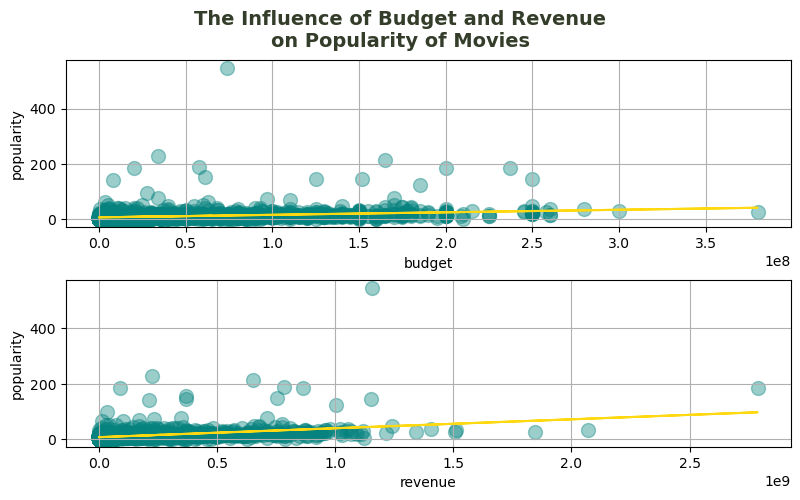

In [96]:
df_plot = df[(df['revenue']!=0) & (df['budget']!=0)]

regr = linear_model.LinearRegression()

plt.figure(figsize=(8,5))
plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=14, weight=600, color='#333d29')

for i, col in enumerate(['budget', 'revenue']):
    regr.fit(np.array(df_plot[col]).reshape(-1,1), df_plot['popularity'].values)
    plt.subplot(2,1,i+1)
    plt.grid()
    plt.scatter(df_plot[col], df_plot['popularity'], alpha=.4, s=100, color='#06837f')
    plt.plot(df_plot[col], df_plot[col]*regr.coef_[0]+regr.intercept_, color='#fed811')
    plt.xlabel(col)
    plt.ylabel('popularity')
plt.tight_layout(pad=0.7);

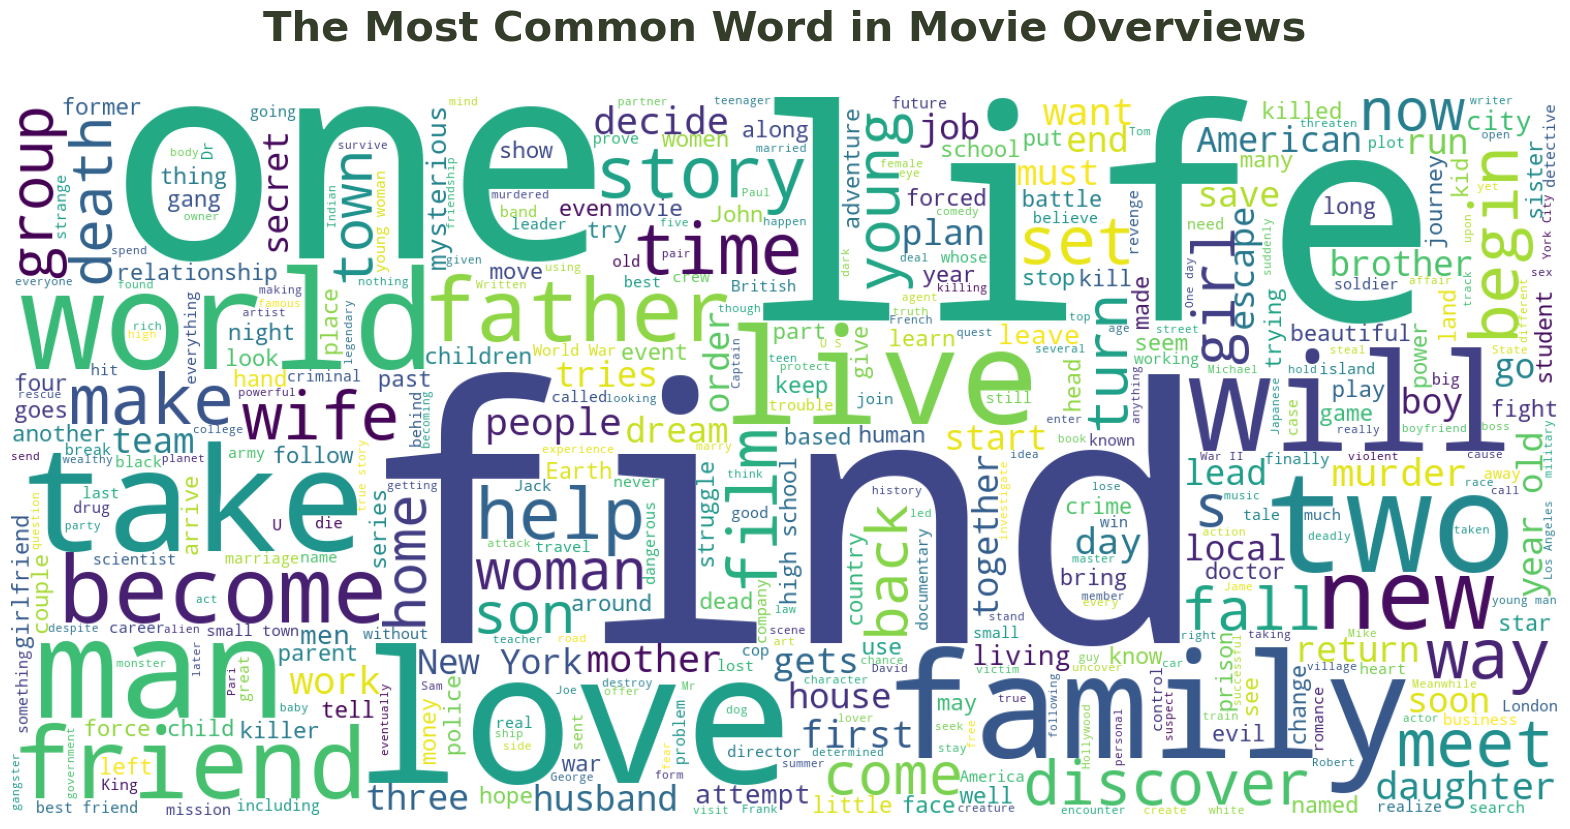

In [97]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10,
                height=700,width=1500,background_color="white").generate(' '.join(df['overview']))
plt.axis('off')
plt.imshow(wc)

(-1.25, 1.25, -1.25, 1.25)

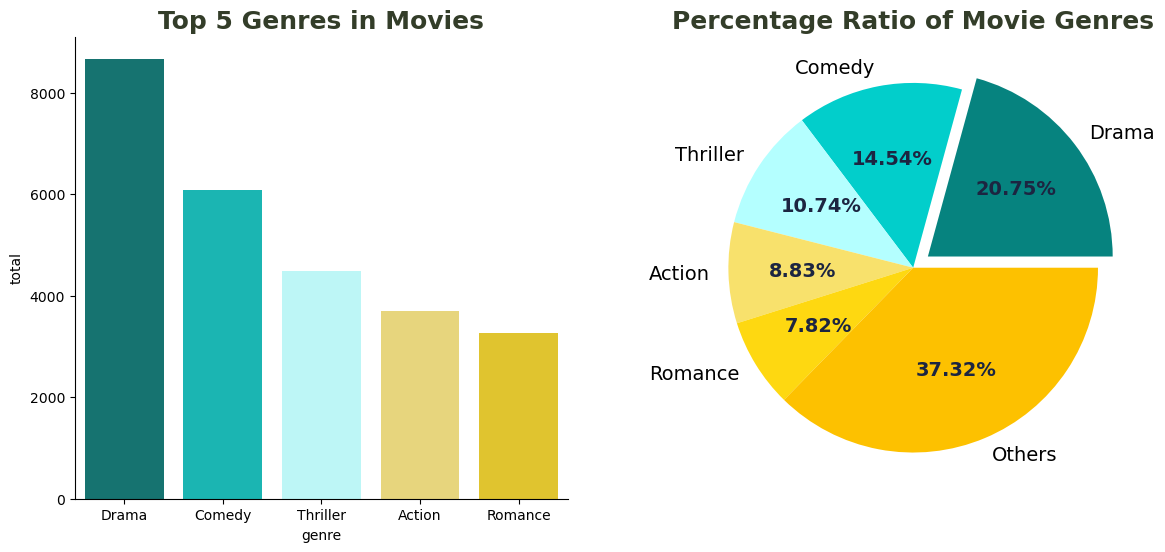

In [139]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0.1,0,0,0,0,0], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

(0.0, 1.0, 0.0, 1.0)

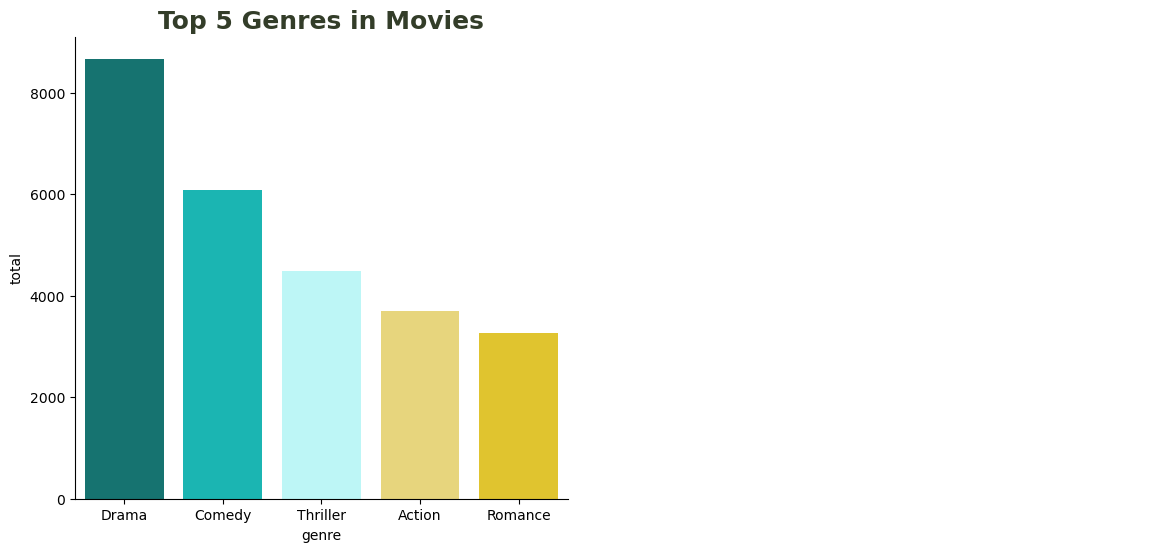

In [146]:
actors_list = []
for i in df['actors']:
    actors_list.extend(i.split(', '))

for actor in actors_list:
    if actor in ['', 'Jr.']:
        actors_list.remove(actor)
        
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()


axes[1].axis('off')

In [135]:
for actor in actors_list:
    if actor in ['', 'Jr.']:
        actors_list.remove(actor)

,genre,total
0,Bess Flowers,164
1,John Wayne,104
2,Christopher Lee,97
3,Samuel L. Jackson,94
4,Robert De Niro,82
